# Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import heapq
from matplotlib.font_manager import FontProperties
from scipy.ndimage import gaussian_filter
from scipy.ndimage import laplace
import csv


# Public Functions

In [ ]:
tick_axis = 20
def get_neighbors(x, y, size):
    """Return 8-connected neighbor coordinates within bounds."""
    neighbors = []
    directions = [(-1,-1), (-1,0), (-1,1), (0,-1), (0,1), (1,-1), (1,0), (1,1)]

    for dx, dy in directions:
        nx, ny = x + dx, y + dy
        if 0 <= nx < size and 0 <= ny < size:
            neighbors.append((nx, ny))
    return neighbors

def plot_tumor_growth(info, grid_size, tumors, title, color_bar=True):
    plt.figure(figsize=(8, 8))  # Create a new figure for each plot
    plt.imshow(info, cmap='Wistia')
    plt.title(title)
    if color_bar:
        cbar = plt.colorbar(shrink=0.8)  # Make the colorbar 80% of its original height
        cbar.set_label('Resistance of Voxels', labelpad=10) # Increased labelpad for more space
        # Set colorbar ticks
        cbar.set_ticks(np.arange(0, 1.1, 0.1))

    y_coords, x_coords = np.where(tumors == 1)
    plt.scatter(x_coords, y_coords, color='black', label='Cancerous Voxel', marker='o', s=3)
    plt.legend()
    plt.xticks(np.arange(0, grid_size+1, tick_axis))
    plt.yticks(np.arange(0, grid_size+1, tick_axis))
    plt.gca().invert_yaxis()
    plt.show()

def plot_oxygen_diffusion(info, grid_size, tumors, title, tumor_flag=True):
    plt.figure(figsize=(7, 7))  # Create a new figure for each plot
    plt.imshow(info, cmap='Blues')
    plt.title(title, fontsize=13, fontweight='bold', pad=15)

    cbar = plt.colorbar(shrink=0.8)  # Make the colorbar 80% of its original height
    cbar.set_label('Oxygen Levels in Voxels', fontsize=13, fontweight='bold', labelpad=10)

    font = FontProperties()
    font.set_size(13)
    # font.set_weight('bold')
    for label in cbar.ax.get_xticklabels():
        label.set_fontproperties(font)
        # label.set_fontsize(14) # Adjusted font size

    for label in cbar.ax.get_yticklabels():
        label.set_fontproperties(font)
        # label.set_fontsize(14) # Adjusted font size

        # Set bold for tick values on the y-axis
    for label in plt.gca().get_yticklabels():
        label.set_fontproperties(font)

    if tumor_flag:
        y_coords, x_coords = np.where(tumors == 1)
        plt.scatter(x_coords, y_coords, color='black', label="Cancerous Voxel", marker='o', s=3)
        plt.legend()

        font = FontProperties()
        # font.set_weight('bold')
        font.set_size(13)
        # font.set_weight('bold')
        for label in plt.gca().get_xticklabels():
            label.set_fontproperties(font)

        # Set bold for tick values on the y-axis
        for label in plt.gca().get_yticklabels():
            label.set_fontproperties(font)

    plt.gca().invert_yaxis() # Add this line
    plt.xticks(np.arange(0, grid_size+1, tick_axis), fontsize=13)
    plt.yticks(np.arange(0, grid_size+1, tick_axis), fontsize=13)
    plt.tick_params(axis='both', which='major', labelsize=13) # You can adjust the labelsize value
    plt.show()

def show_result(navigation, results, tumor_distribution, ensemble_count):
    print(f"Cured Voxels Results of {navigation}:")
    print(f"Mean: {np.mean(results)} out of {np.sum(tumor_distribution)}")
    print(f"Effectiveness: {round(float(np.mean(results) / np.sum(tumor_distribution)) * 100, 2)}%")
    print(f"St. Deviation: {np.std(results)}")

    plt.figure(figsize=(12, 5))
    plt.scatter(list(range(len(results))), results, label=navigation, marker='o', s=3)
    plt.title(f"Ensemble Simulations, E = {ensemble_count} of TDD using {navigation} Navigation")
    plt.grid(axis='y')
    plt.show()

def plot_tumor_evolution(time_steps, results_tumors, ensemble_count):
    tumor_evolution_list = []
    for i in (range(int(time_steps / 10))):
        # print(i)
        tumor_sum = 0
        for tumor_list in results_tumors:
            if np.isnan(tumor_list[i]):
                tumor_list[i] = 0
            tumor_sum += tumor_list[i]
        tumor_evolution_list.append(tumor_sum / len(results_tumors))

    plt.figure(figsize=(10, 5))
    plt.plot(tumor_evolution_list, linewidth=1)
    # plt.title(f"Ensemble Simulation Results, E = {ensemble_count}, \n Mean Number of Cancerous Voxels Over {int((time_steps * 0.1) / 60)} Hours for Each Simulation")
    plt.xlabel("Time Steps")
    plt.ylabel("Number of Cancerous Voxels")
    plt.grid(True)
    plt.show()

    return tumor_evolution_list

# System and Environment Classes

In [ ]:
class System_Class:
    def __init__(self, x, y, receptor_list):
        self.x = x
        self.y = y
        self.bgf = -1
        self.direction = -1
        self.last_bgf = -1
        self.last_direction = -1
        # self.chemotaxis = True
        # self.tumble_mode = True
        self.find_tumor = False
        self.receptors = receptor_list
        self.released_drug = 0
        self.first_cure = 0
        self.last_cure = 0
        self.speed = 1
        self.state = "Chemotaxis" # / "Entropy"
        self.time_in_state = 0.0

    def get_directions_probabilities(self, bgf_list):
        directions_probabilities = []
        total = np.sum(bgf_list)
        for bgf in bgf_list:
            # prob = (1 - bgf) / total
            prob = (38.0 - bgf) / total
            directions_probabilities.append(prob)
        return directions_probabilities

    def get_directions_entropy(self, directions_probabilities):
        directions_entropy = []
        for p in directions_probabilities:
            p = max(p, 0.00001)
            directions_entropy.append(-p * np.log2(p))
        return directions_entropy

    def choose_direction_tumble(self, bgf_list):
        total = np.sum(bgf_list)
        directions_probabilities = []

        for bgf in bgf_list:
            # prob = (1 - bgf) / total
            prob = (38.0 - bgf) / total
            directions_probabilities.append(prob)

        # Normalize probabilities
        probabilities_sum = np.sum(directions_probabilities)
        if probabilities_sum > 0:
            directions_probabilities = [p / probabilities_sum for p in directions_probabilities]
        else:
            # Handle the case where all probabilities are zero (e.g., uniform probability)
            directions_probabilities = [1.0 / len(bgf_list)] * len(bgf_list)

        # Select an index randomly based on the probabilities
        d = np.random.choice(len(bgf_list), p=directions_probabilities)
        if d == 0:
            direction = (-1,-1)
        elif d == 1:
            direction = (-1, 0)
        elif d == 2:
            direction = (-1, 1)
        elif d == 3:
            direction = (0,-1)
        elif d == 4:
            direction = (0, 1)
        elif d == 5:
            direction = (1,-1)
        elif d == 6:
            direction = (1, 0)
        elif d == 7:
            direction = (1, 1)

        return direction

    def choose_direction(self, bgf_list):
        directions_probabilities = self.get_directions_probabilities(bgf_list)
        directions_entropy       = self.get_directions_entropy(directions_probabilities)

        d = np.argmax(directions_entropy)
        if d == 0:
            direction = (-1,-1)
        elif d == 1:
            direction = (-1, 0)
        elif d == 2:
            direction = (-1, 1)
        elif d == 3:
            direction = (0,-1)
        elif d == 4:
            direction = (0, 1)
        elif d == 5:
            direction = (1,-1)
        elif d == 6:
            direction = (1, 0)
        elif d == 7:
            direction = (1, 1)

        return direction

class Environment_Class:
    def __init__(self, width, height, bgf_values, tumors):
        self.width  = width
        self.height = height
        self.tumors = tumors
        self.bgf    = bgf_values
        self.cancer_voxels = []

    def check_reflection(self, dx, dy, x, y, N):
        if (x + dx) <= 0 or (x + dx) >= N-1:
            dx = -dx
        if (y + dy) <= 0 or (y + dy) >= N-1:
            dy = -dy

        return (dx, dy)

    def get_voxel_neighbors(self, x, y):
        bgf_values = []
        bgf_values.append(self.bgf[x-1][y-1])
        bgf_values.append(self.bgf[x-1][y])
        bgf_values.append(self.bgf[x-1][y+1])
        bgf_values.append(self.bgf[x][y-1])
        bgf_values.append(self.bgf[x][y+1])
        bgf_values.append(self.bgf[x+1][y-1])
        bgf_values.append(self.bgf[x+1][y])
        bgf_values.append(self.bgf[x+1][y+1])
        return bgf_values

# TME Initialization

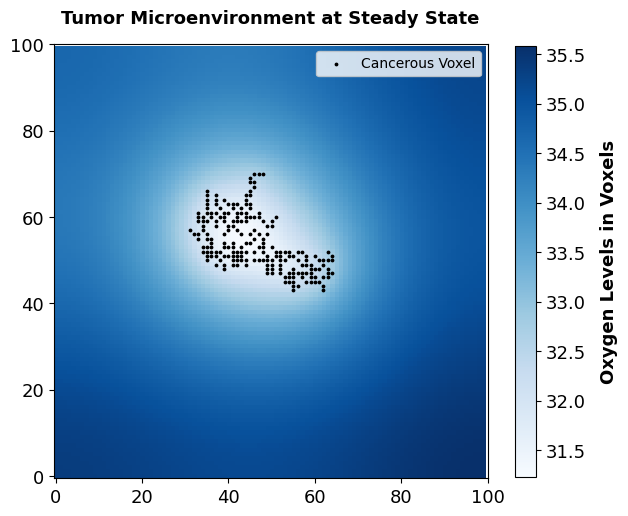

In [ ]:
grid_size = 100

tumor_mask = pd.read_csv("tumor_100.csv", header=None)
substrate = pd.read_csv("oxygen_100.csv", header=None)
plot_oxygen_diffusion(substrate, grid_size, tumor_mask, f"Tumor Microenvironment at Steady State", tumor_flag=True)


# Ensemble Chemotaxis

In [ ]:
directions = [(-1,-1), (-1,0), (-1,1), (0,-1), (0,1), (1,-1), (1,0), (1,1)]
sc_path = []
receptors = [1, 2, 3, 4, 5, 6, 7, 8, 9]

dx = 100.0                 # μm per voxel (100 µm)
dt = 0.6                   # seconds
T = 1000 * 60               # Total simulation time (in seconds)
D  = 3.33e3                # diffusion coefficient in μm²/s
lambda_decay = 0.0008333   # oxygen uptake rate in sec⁻¹
time_steps = int(T / dt)
print(time_steps)

E = 1000 # Ensemble simulations

60000


Simulation 100
Simulation 200
Simulation 300
Simulation 400
Simulation 500
Simulation 600
Simulation 700
Simulation 800
Simulation 900
Simulation 1000
Cured Voxels Results of Chemotaxis:
Mean: 64.723 out of 206
Effectiveness: 31.42%
St. Deviation: 48.67410267277661


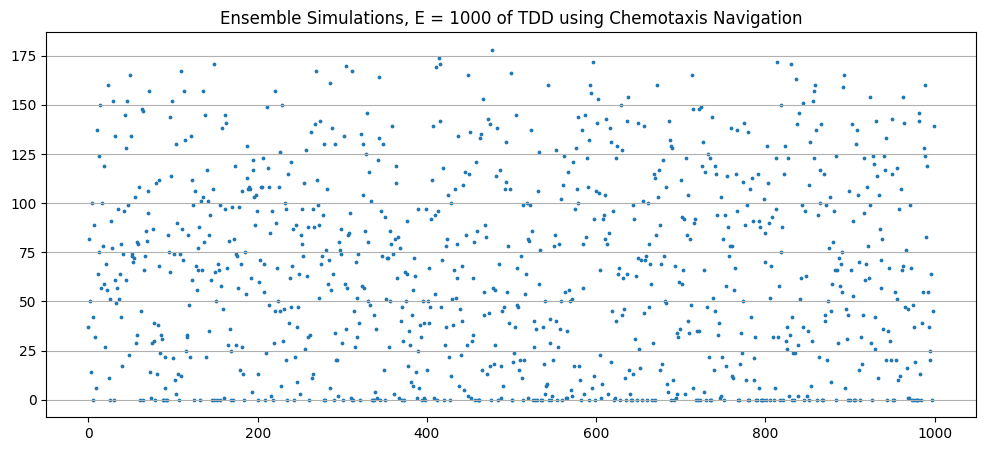

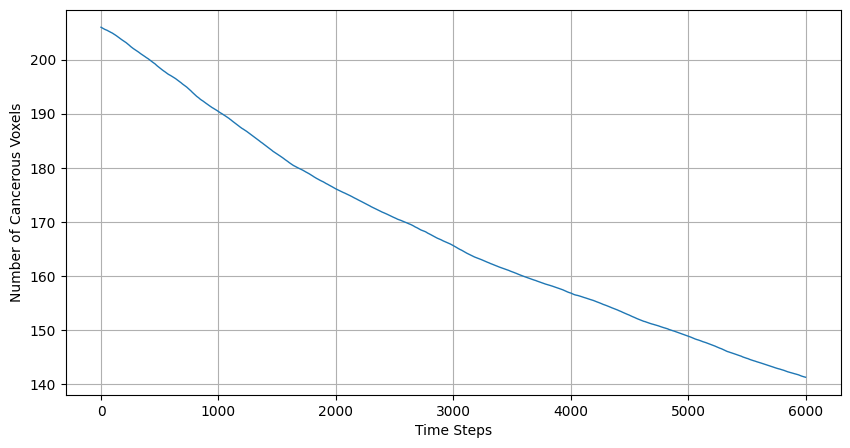

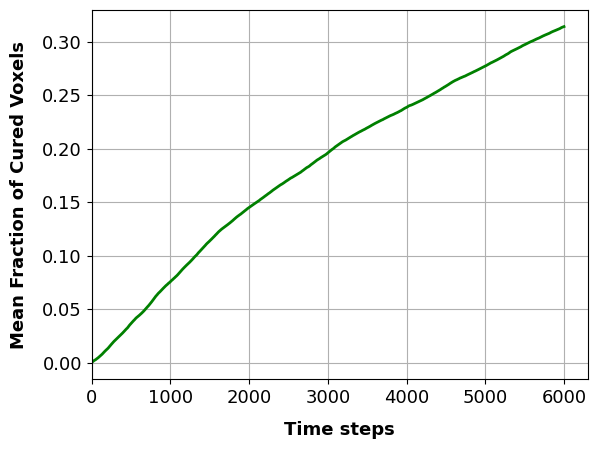

In [ ]:
results_chemotaxis = []
results_tumors_chemotaxis = []

for e in np.arange(1, E+1):
    initial_x = random.randint(3, 96)
    initial_y = random.randint(3, 96)
    sc = System_Class(initial_x, initial_y, receptors)
    env_chemotaxis = Environment_Class(grid_size, grid_size, substrate.copy().values, tumor_mask.copy().values)

    if e % 100 == 0:
        print(f"Simulation {e}")

    for t in np.arange(1, time_steps+1):
        # Environmental Dynamics
        laplacian = laplace(env_chemotaxis.bgf, mode='reflect')                  # Laplacian using scipy.ndimage
        diffusion_term = D * laplacian / dx**2
        decay_term = -lambda_decay * env_chemotaxis.bgf * env_chemotaxis.tumors  # Decay only in tumor voxels
        env_chemotaxis.bgf += dt * (diffusion_term + decay_term)                 # Explicit update
        env_chemotaxis.bgf = np.clip(env_chemotaxis.bgf, 0, 38.0)                # clamp to physical range

        if t % 10 > 0:
            continue

        bgf_list = env_chemotaxis.get_voxel_neighbors(sc.x, sc.y)
        # sc.state = "Tumble"
        sc.direction = sc.choose_direction_tumble(bgf_list)

        # Movement
        # sc.state = "Run"
        sc.direction = env_chemotaxis.check_reflection(sc.direction[0], sc.direction[1], sc.x, sc.y, grid_size)
        sc.x = sc.x + sc.direction[0]
        sc.y = sc.y + sc.direction[1]

        # Check the voxel
        x, y = sc.x, sc.y
        sc.bgf = env_chemotaxis.bgf[x][y]
        sc.find_tumor = env_chemotaxis.tumors[x][y] == 1
        if sc.find_tumor:
            sc.released_drug += 1
            env_chemotaxis.tumors[x][y] = 0
            env_chemotaxis.bgf[x][y] = 38.0

        env_chemotaxis.cancer_voxels.append(np.sum(env_chemotaxis.tumors))

    results_chemotaxis.append(sc.released_drug)
    results_tumors_chemotaxis.append(env_chemotaxis.cancer_voxels)

show_result("Chemotaxis", results_chemotaxis, tumor_mask.values, E)
tumor_evolution_chemotaxis = plot_tumor_evolution(time_steps, results_tumors_chemotaxis, E)

total_tumors = np.sum(tumor_mask.values)
cured_chemotaxis = [ (total_tumors - x) / total_tumors for x in tumor_evolution_chemotaxis]

plt.plot(cured_chemotaxis, linewidth=2, color='green', label="Chemotaxis")
plt.xlim(0, None)
plt.xlim(0, None)
# plt.title(f"Average Fraction of Cured Voxels over Ensemble Simulations", fontsize=13, fontweight='bold', pad=15)
plt.xlabel("Time steps", fontsize=13, fontweight='bold', labelpad=10)
plt.ylabel("Mean Fraction of Cured Voxels", fontsize=13, fontweight='bold', labelpad=10)
plt.tick_params(axis='both', which='major', labelsize=13) # You can adjust the labelsize value
# plt.legend(['Random', 'Chemotaxis', 'Hybrid'], fontsize=12)
plt.grid(True)
plt.show()


# Ensemble Hybrid

In [ ]:
directions = [(-1,-1), (-1,0), (-1,1), (0,-1), (0,1), (1,-1), (1,0), (1,1)]
sc_path = []
receptors = [1, 2, 3, 4, 5, 6, 7, 8, 9]

dx = 100.0                 # μm per voxel (100 µm)
dt = 0.6                   # seconds
T = 1000 * 60               # Total simulation time (in seconds)
D  = 3.33e3                # diffusion coefficient in μm²/s
lambda_decay = 0.0008333   # oxygen uptake rate in sec⁻¹
time_steps = int(T / dt)
print(time_steps)

E = 1000 # Ensemble simulations

100000


In [ ]:
results_hybrid = []
results_tumors_hybrid = []

m = 0
M = 10

for e in np.arange(1, E+1):
    initial_x = random.randint(3, 96)
    initial_y = random.randint(3, 96)
    sc = System_Class(initial_x, initial_y, receptors)
    env_hybrid = Environment_Class(grid_size, grid_size, substrate.copy().values, tumor_mask.copy().values)

    if e % 50 == 0:
        print(f"Simulation {e}")

    for t in np.arange(1, time_steps+1):
        # Environmental Dynamics
        laplacian = laplace(env_hybrid.bgf, mode='reflect')          # Laplacian using scipy.ndimage
        diffusion_term = D * laplacian / dx**2
        decay_term = -lambda_decay * env_hybrid.bgf * env_hybrid.tumors   # Decay only in tumor voxels
        env_hybrid.bgf += dt * (diffusion_term + decay_term)         # Explicit update
        env_hybrid.bgf = np.clip(env_hybrid.bgf, 0, 38.0)                 # clamp to physical range

        if t % 10 > 0:
            continue

        bgf_list = env_hybrid.get_voxel_neighbors(sc.x, sc.y)

        # Choose Direction
        if sc.state == "Chemotaxis":
            sc.direction = sc.choose_direction_tumble(bgf_list)
            sc.direction = env_hybrid.check_reflection(sc.direction[0], sc.direction[1], sc.x, sc.y, grid_size)
        else:
            sc.direction = sc.choose_direction(bgf_list)

        # Movement
        sc.direction = env_hybrid.check_reflection(sc.direction[0], sc.direction[1], sc.x, sc.y, grid_size)
        sc.x = sc.x + sc.direction[0]
        sc.y = sc.y + sc.direction[1]

        # Check the voxel
        x, y = sc.x, sc.y
        sc.bgf = env_hybrid.bgf[x][y]
        sc.find_tumor = env_hybrid.tumors[x][y] == 1
        if sc.find_tumor:
            sc.state = "Entropy"
            m = 0
            sc.released_drug += 1
            env_hybrid.tumors[x][y] = 0
            env_hybrid.bgf[x][y] = 38.0
        else:
            if sc.state == "Entropy":
                m += 1
                if m >= M:
                    sc.state = "Chemotaxis"

        # sc_path.append(tuple([x, y]))
        env_hybrid.cancer_voxels.append(np.sum(env_hybrid.tumors))

    results_hybrid.append(sc.released_drug)
    results_tumors_hybrid.append(env_hybrid.cancer_voxels)


show_result("Hybrid", results_hybrid, tumor_mask.values, E)
tumor_evolution_hybrid = plot_tumor_evolution(time_steps, results_tumors_hybrid, E)

total_tumors = np.sum(tumor_mask.values)
cured_hybrid = [ (total_tumors - x) / total_tumors for x in tumor_evolution_hybrid]

plt.plot(cured_hybrid, linewidth=2, color='green', label="Hybrid")
plt.xlim(0, None)
plt.xlim(0, None)
# plt.title(f"Average Fraction of Cured Voxels over Ensemble Simulations", fontsize=13, fontweight='bold', pad=15)
plt.xlabel("Time steps", fontsize=13, fontweight='bold', labelpad=10)
plt.ylabel("Mean Fraction of Cured Voxels", fontsize=13, fontweight='bold', labelpad=10)
plt.tick_params(axis='both', which='major', labelsize=13) # You can adjust the labelsize value
# plt.legend(['Random', 'Chemotaxis', 'Hybrid'], fontsize=12)
plt.grid(True)
plt.show()



Simulation 50
Simulation 100
Simulation 150
Simulation 200
Simulation 250
Simulation 300
Simulation 350
Simulation 400
Simulation 450
Simulation 500
Simulation 550
Simulation 600
Simulation 650
Simulation 700
Simulation 750


In [ ]:
# Save results_hybrid to a CSV file
with open('results_hybrid.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(results_hybrid)

# Save results_tumors_hybrid to a CSV file
with open('results_tumors_hybrid.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(results_tumors_hybrid)

print("Results saved to results_hybrid.csv and results_tumors_hybrid.csv")

In [ ]:
# Read results_chemotaxis from CSV
with open('results_hybrid.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    results_hybrid_read = list(reader)[0] # Read the first and only row

# Convert elements to appropriate type if necessary (they are read as strings)
results_hybrid_read = [int(x) for x in results_chemotaxis_read]

# Read results_tumors_chemotaxis from CSV
with open('results_tumors_hybrid.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    results_tumors_hybrid_read = list(reader)

# Convert elements to appropriate type if necessary (they are read as strings)
results_tumors_hybrid_read = [[float(x) for x in row] for row in results_tumors_chemotaxis_read]

print("Data read from CSV files.")
print("results_hybrid_read (first 10 elements):", results_chemotaxis_read[:10])
print("results_tumors_hybrid_read (first row):", results_tumors_chemotaxis_read[0])

# Single Hybrid

In [ ]:
directions = [(-1,-1), (-1,0), (-1,1), (0,-1), (0,1), (1,-1), (1,0), (1,1)]
sc_path = []
receptors = [1, 2, 3, 4, 5, 6, 7, 8, 9]

initial_x = 80 # random.randint(3, 96)
initial_y = 20 # random.randint(3, 96)
sc = System_Class(initial_x, initial_y, receptors)
env_hybrid = Environment_Class(grid_size, grid_size, substrate.copy().values, tumor_mask.copy().values)

dx = 100.0                 # μm per voxel (100 µm)
dt = 0.6                   # seconds
T = 500 * 60               # Total simulation time (in seconds)
D  = 3.33e3                # diffusion coefficient in μm²/s
lambda_decay = 0.0008333   # oxygen uptake rate in sec⁻¹
time_steps = int(T / dt)
print(time_steps)

50000


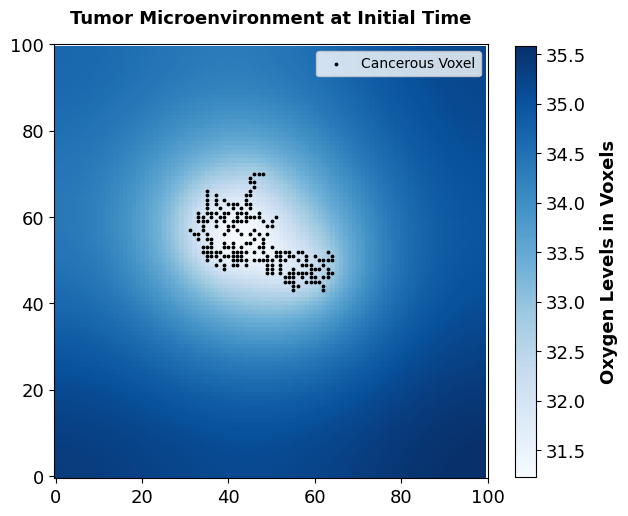

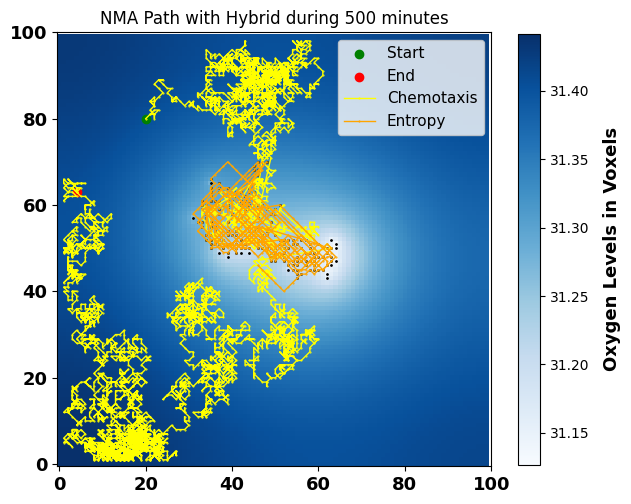

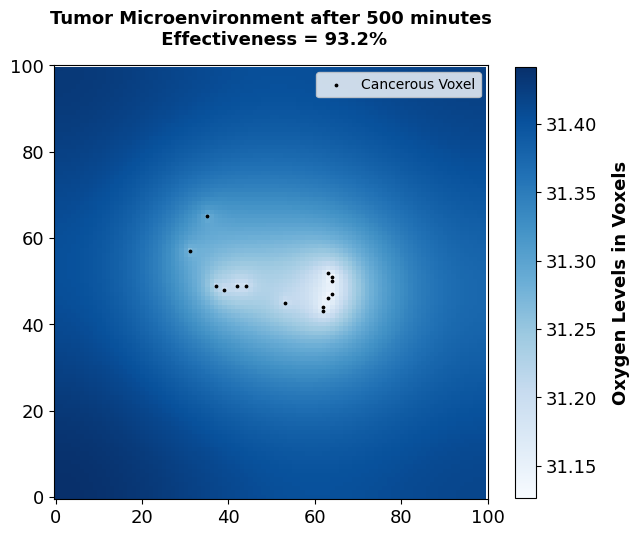

In [ ]:
results_hybrid = []
# sc_path_hybrid = []
sc_path_chemotaxis = []
sc_path_entropy = []
sc_states = []

m = 0
M = 10

plot_oxygen_diffusion(env_hybrid.bgf, grid_size, env_hybrid.tumors, f"Tumor Microenvironment at Initial Time", tumor_flag=True)

for t in np.arange(1, time_steps+1):
    # Environmental Dynamics
    laplacian = laplace(env_hybrid.bgf, mode='reflect')          # Laplacian using scipy.ndimage
    diffusion_term = D * laplacian / dx**2
    decay_term = -lambda_decay * env_hybrid.bgf * env_hybrid.tumors   # Decay only in tumor voxels
    env_hybrid.bgf += dt * (diffusion_term + decay_term)         # Explicit update
    env_hybrid.bgf = np.clip(env_hybrid.bgf, 0, 38.0)                 # clamp to physical range

    if t % 10 > 0:
        continue

    bgf_list = env_hybrid.get_voxel_neighbors(sc.x, sc.y)
    # Choose Direction
    if sc.state == "Chemotaxis":
        sc_path_chemotaxis.append(tuple([sc.x, sc.y]))
        sc_states.append(sc.state)
        sc.direction = sc.choose_direction_tumble(bgf_list)
        sc.direction = env_hybrid.check_reflection(sc.direction[0], sc.direction[1], sc.x, sc.y, grid_size)
    else:
        sc.direction = sc.choose_direction(bgf_list)
        sc_path_entropy.append(tuple([sc.x, sc.y]))

    # Movement
    sc.direction = env_hybrid.check_reflection(sc.direction[0], sc.direction[1], sc.x, sc.y, grid_size)
    sc.x = sc.x + sc.direction[0]
    sc.y = sc.y + sc.direction[1]

    # Check the voxel
    x, y = sc.x, sc.y
    sc.bgf = env_hybrid.bgf[x][y]
    sc.find_tumor = env_hybrid.tumors[x][y] == 1
    if sc.find_tumor:
        sc.state = "Entropy"
        m = 0
        sc.released_drug += 1
        env_hybrid.tumors[x][y] = 0
        env_hybrid.bgf[x][y] = 38.0
    else:
        if sc.state == "Entropy":
            m += 1
            if m >= M:
                sc.state = "Chemotaxis"

    # sc_path_hybrid.append(tuple([sc.x, sc.y]))

plt.figure(figsize=(7, 7))
plt.imshow(env_hybrid.bgf, cmap="Blues", vmin=np.min(env_hybrid.bgf), vmax=np.max(env_hybrid.bgf))
cbar = plt.colorbar(shrink=0.8)  # Make the colorbar 80% of its original height
cbar.set_label('Oxygen Levels in Voxels', fontsize=13, fontweight='bold', labelpad=10) # Adjusted font size and weight
plt.title(f"NMA Path with Hybrid during {T // 60} minutes")
# path_x, path_y = zip(*sc_path_hybrid)
if len(sc_path_chemotaxis) > 0:
    path_x_chemotaxis, path_y_chemotaxis = zip(*sc_path_chemotaxis)
else:
    path_x_chemotaxis, path_y_chemotaxis = [], []
if len(sc_path_entropy) > 0:
    path_x_entropy, path_y_entropy = zip(*sc_path_entropy)
else:
    path_x_entropy, path_y_entropy = [], []

# plt.plot(path_y, path_x, marker='.', color='yellow', linewidth=1, markersize=1, label='SC Path')
# plt.scatter([sc_path_hybrid[0][1]], [sc_path_hybrid[0][0]], color='green', label='Start')
# plt.scatter([sc_path_hybrid[-1][1]], [sc_path_hybrid[-1][0]], color='red', label='End')

plt.scatter([sc_path_chemotaxis[0][1]], [sc_path_chemotaxis[0][0]], color='green', label='Start')
plt.scatter([sc_path_chemotaxis[-1][1]], [sc_path_chemotaxis[-1][0]], color='red', label='End')
plt.plot(path_y_chemotaxis, path_x_chemotaxis, marker='.', color='yellow', linewidth=1, markersize=1, label='Chemotaxis')
plt.plot(path_y_entropy, path_x_entropy, marker='.', color='orange', linewidth=1, markersize=1, label='Entropy')

y_coords, x_coords = np.where(tumor_mask == 1)
plt.scatter(x_coords, y_coords, color='black', marker='o', s=1)
plt.xticks(np.arange(0, grid_size+1, tick_axis), fontsize=13, fontweight='bold')
plt.yticks(np.arange(0, grid_size+1, tick_axis), fontsize=13, fontweight='bold')
plt.legend(fontsize=11)
plt.gca().invert_yaxis()
plt.show()

effectiveness_hybrid = round((sc.released_drug / np.sum(tumor_mask.values)) * 100, 2)
plot_oxygen_diffusion(env_hybrid.bgf, grid_size, env_hybrid.tumors, f"Tumor Microenvironment after {T // 60} minutes\n Effectiveness = {effectiveness_hybrid}%", tumor_flag=True)


# Single Chemotaxis

In [ ]:
directions = [(-1,-1), (-1,0), (-1,1), (0,-1), (0,1), (1,-1), (1,0), (1,1)]
sc_path = []
receptors = [1, 2, 3, 4, 5, 6, 7, 8, 9]

initial_x = 80 # random.randint(3, 96)
initial_y = 20 # random.randint(3, 96)
sc = System_Class(initial_x, initial_y, receptors)
env_chemotaxis = Environment_Class(grid_size, grid_size, substrate.copy().values, tumor_mask.copy().values)

dx = 100.0                 # μm per voxel (100 µm)
dt = 0.6                   # seconds
T = 500 * 60               # Total simulation time (in seconds)
D  = 3.33e3                # diffusion coefficient in μm²/s
lambda_decay = 0.0008333   # oxygen uptake rate in sec⁻¹
time_steps = int(T / dt)
print(time_steps)

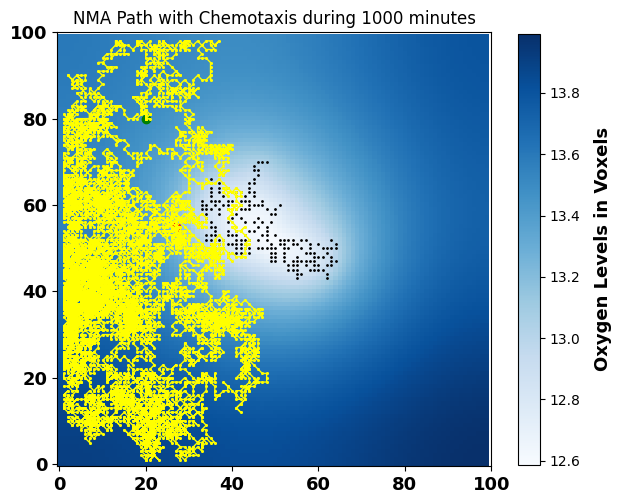

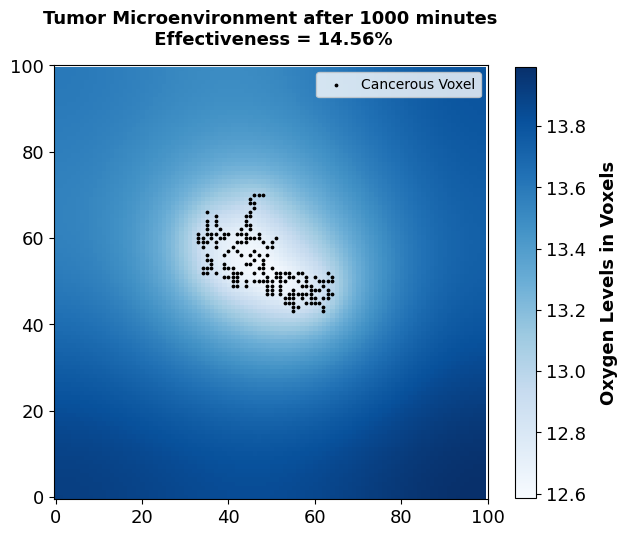

In [ ]:
for t in np.arange(1, time_steps+1):

    # Environmental Dynamics
    laplacian = laplace(env_chemotaxis.bgf, mode='reflect')       # Laplacian using scipy.ndimage
    diffusion_term = D * laplacian / dx**2
    decay_term = -lambda_decay * env_chemotaxis.bgf * env_chemotaxis.tumors  # Decay only in tumor voxels
    env_chemotaxis.bgf += dt * (diffusion_term + decay_term)      # Explicit update
    env_chemotaxis.bgf = np.clip(env_chemotaxis.bgf, 0, 38.0)                 # clamp to physical range

    if t % 10 == 0:
        bgf_list = env_chemotaxis.get_voxel_neighbors(sc.x, sc.y)
        # sc.state = "Tumble"
        sc.direction = sc.choose_direction_tumble(bgf_list)

        # Movement
        # sc.state = "Run"
        sc.direction = env_chemotaxis.check_reflection(sc.direction[0], sc.direction[1], sc.x, sc.y, grid_size)
        sc.x = sc.x + sc.direction[0]
        sc.y = sc.y + sc.direction[1]

        # Check the voxel
        x, y = sc.x, sc.y
        sc.bgf = env_chemotaxis.bgf[x][y]
        sc.find_tumor = env_chemotaxis.tumors[x][y] == 1
        if sc.find_tumor:
            sc.released_drug += 1
            env_chemotaxis.tumors[x][y] = 0
            env_chemotaxis.bgf[x][y] = 38.0

    sc_path.append(tuple([sc.x, sc.y]))

plt.figure(figsize=(7, 7))
plt.imshow(env_chemotaxis.bgf, cmap="Blues", vmin=np.min(env_chemotaxis.bgf), vmax=np.max(env_chemotaxis.bgf))
cbar = plt.colorbar(shrink=0.8)  # Make the colorbar 80% of its original height
cbar.set_label('Oxygen Levels in Voxels', fontsize=13, fontweight='bold', labelpad=10) # Adjusted font size and weight
plt.title(f"NMA Path with Chemotaxis during {T // 60} minutes")
path_x, path_y = zip(*sc_path)
plt.plot(path_y, path_x, marker='.', color='yellow', linewidth=1, markersize=1, label='SC Path')
plt.scatter([sc_path[0][1]], [sc_path[0][0]], color='green', label='Start')
plt.scatter([sc_path[-1][1]], [sc_path[-1][0]], color='red', label='End')
y_coords, x_coords = np.where(tumor_mask == 1)
plt.scatter(x_coords, y_coords, color='black', marker='o', s=1, label='Value = 1')
plt.xticks(np.arange(0, grid_size+1, tick_axis), fontsize=13, fontweight='bold')
plt.yticks(np.arange(0, grid_size+1, tick_axis), fontsize=13, fontweight='bold')
plt.gca().invert_yaxis()
plt.show()

effectiveness_chemotaxis = round((sc.released_drug / np.sum(tumor_mask.values)) * 100, 2)
plot_oxygen_diffusion(env_chemotaxis.bgf, grid_size, env_chemotaxis.tumors, f"Tumor Microenvironment after {T // 60} minutes\n Effectiveness = {effectiveness_chemotaxis}%", tumor_flag=True)
